In [1]:
# --------------------------------------- Create by yokkm ---------------------------------------#
# ----- data from https://www.kaggle.com/kwadwoofosu/predict-test-scores-of-students/code 
# ----- objective: to predict test scores - Post test
# ----- Start date :24/07/21
# ----- Last edited :25/07/21

In [45]:
# import standard libraries


import pandas as pd
import os
import sys
import numpy as np
import re

from IPython.core.display import display,HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))
# %reload_ext sparksql_magic

pd.set_option('display.max_rows',None)

In [46]:
from termcolor import colored, cprint
# import plotting libraries

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [47]:
# import dataset
# data file locate in the same directory with code file

local_path = os.getcwd()
path_to_file = local_path+'/test_scores.csv'

# # read & show sample file
# df = pd.read_csv(path_file)
# df.head()

In [48]:
df = spark.read.option("header",True).csv(path_to_file)
df.show(3,False)

+------+--------------+-----------+---------+---------------+---------+----------+------+----------------+-------+--------+
|school|school_setting|school_type|classroom|teaching_method|n_student|student_id|gender|lunch           |pretest|posttest|
+------+--------------+-----------+---------+---------------+---------+----------+------+----------------+-------+--------+
|ANKYI |Urban         |Non-public |6OL      |Standard       |20.0     |2FHT3     |Female|Does not qualify|62.0   |72.0    |
|ANKYI |Urban         |Non-public |6OL      |Standard       |20.0     |3JIVH     |Female|Does not qualify|66.0   |79.0    |
|ANKYI |Urban         |Non-public |6OL      |Standard       |20.0     |3XOWE     |Male  |Does not qualify|64.0   |76.0    |
+------+--------------+-----------+---------+---------------+---------+----------+------+----------------+-------+--------+
only showing top 3 rows



In [49]:
df.printSchema()

root
 |-- school: string (nullable = true)
 |-- school_setting: string (nullable = true)
 |-- school_type: string (nullable = true)
 |-- classroom: string (nullable = true)
 |-- teaching_method: string (nullable = true)
 |-- n_student: string (nullable = true)
 |-- student_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- pretest: string (nullable = true)
 |-- posttest: string (nullable = true)



In [50]:
df = df.withColumn('n_student',col('n_student').cast('int'))\
.withColumn('pretest',col('pretest').cast('int'))\
.withColumn('posttest',col('posttest').cast('int'))
df.printSchema()

root
 |-- school: string (nullable = true)
 |-- school_setting: string (nullable = true)
 |-- school_type: string (nullable = true)
 |-- classroom: string (nullable = true)
 |-- teaching_method: string (nullable = true)
 |-- n_student: integer (nullable = true)
 |-- student_id: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- lunch: string (nullable = true)
 |-- pretest: integer (nullable = true)
 |-- posttest: integer (nullable = true)



## Data exploration

In [8]:
# show number of unique value in all columns except student id, pretest, posttest score
df_col_list = df.select([i for i in df.columns if i not in 
                       {'student_id','pretest','posttest'}])
for i in df_col_list.columns:
    print(colored('--Showing-- Column --> {}'.format(i) ,'blue', attrs=['reverse', 'blink']))
    print('* number of unique value in',i)
    print(df.select(i).distinct().count())

--Showing-- Column --> school
* number of unique value in school
23
--Showing-- Column --> school_setting
* number of unique value in school_setting
3
--Showing-- Column --> school_type
* number of unique value in school_type
2
--Showing-- Column --> classroom
* number of unique value in classroom
97
--Showing-- Column --> teaching_method
* number of unique value in teaching_method
2
--Showing-- Column --> n_student
* number of unique value in n_student
18
--Showing-- Column --> gender
* number of unique value in gender
2
--Showing-- Column --> lunch
* number of unique value in lunch
2


In [9]:
# show number of student and school by school setting
df.groupby(['school_setting'])\
.agg(countDistinct('student_id').alias('ttl_student')
    ,countDistinct('school').alias('ttl_school')
    ,avg('pretest').cast('decimal(12,2)').alias('avg_pre')
    ,avg('posttest').cast('decimal(12,2)').alias('avg_post'))\
.select('school_setting','ttl_student','ttl_school'
       ,((col('ttl_student')/col('ttl_school')).cast('decimal(12,2)').alias('avg_std/sch'))
       ,'avg_pre','avg_post')\
.show(100,False)

+--------------+-----------+----------+-----------+-------+--------+
|school_setting|ttl_student|ttl_school|avg_std/sch|avg_pre|avg_post|
+--------------+-----------+----------+-----------+-------+--------+
|Urban         |906        |9         |100.67     |49.88  |61.75   |
|Suburban      |717        |7         |102.43     |63.84  |76.04   |
|Rural         |510        |7         |72.86      |51.49  |64.05   |
+--------------+-----------+----------+-----------+-------+--------+



In [10]:
# show number of student and school by school type

df.groupby(['school_setting','school_type'])\
.agg(countDistinct('student_id').alias('ttl_student')
    ,countDistinct('school').alias('ttl_school'))\
.select('school_setting','school_type','ttl_student','ttl_school'
       ,((col('ttl_student')/col('ttl_school')).cast('decimal(12,2)').alias('avg_std/sch')))\
.orderBy('ttl_student', ascending=False)\
.show(100,False)

+--------------+-----------+-----------+----------+-----------+
|school_setting|school_type|ttl_student|ttl_school|avg_std/sch|
+--------------+-----------+-----------+----------+-----------+
|Urban         |Public     |645        |5         |129.00     |
|Suburban      |Public     |524        |5         |104.80     |
|Rural         |Public     |413        |5         |82.60      |
|Urban         |Non-public |261        |4         |65.25      |
|Suburban      |Non-public |193        |2         |96.50      |
|Rural         |Non-public |97         |2         |48.50      |
+--------------+-----------+-----------+----------+-----------+



In [11]:
# show number of type of classroom by school setting, and type

df.groupby(['school_setting','school_type'])\
.agg(countDistinct('student_id').alias('ttl_student')
    ,countDistinct('school').alias('ttl_school')
    ,countDistinct('classroom').alias('ttl_clsrm'))\
.select('school_setting','school_type','ttl_student','ttl_school','ttl_clsrm')\
.orderBy('ttl_student', ascending=False)\
.show(100,False)

+--------------+-----------+-----------+----------+---------+
|school_setting|school_type|ttl_student|ttl_school|ttl_clsrm|
+--------------+-----------+-----------+----------+---------+
|Urban         |Public     |645        |5         |24       |
|Suburban      |Public     |524        |5         |23       |
|Rural         |Public     |413        |5         |20       |
|Urban         |Non-public |261        |4         |13       |
|Suburban      |Non-public |193        |2         |11       |
|Rural         |Non-public |97         |2         |6        |
+--------------+-----------+-----------+----------+---------+



In [12]:
# show number of student and school by qualification for free lunch by locations

df.groupby(['school_setting','lunch'])\
.agg(countDistinct('student_id').alias('ttl_student')
    ,countDistinct('school').alias('ttl_school')
    ,avg('pretest').cast('decimal(12,2)').alias('avg_pre')
    ,avg('posttest').cast('decimal(12,2)').alias('avg_post'))\
.select('school_setting','lunch','ttl_student','ttl_school'
       ,'avg_pre','avg_post')\
.orderBy('ttl_student', ascending=False)\
.show(100,False)

+--------------+--------------------------------+-----------+----------+-------+--------+
|school_setting|lunch                           |ttl_student|ttl_school|avg_pre|avg_post|
+--------------+--------------------------------+-----------+----------+-------+--------+
|Urban         |Does not qualify                |474        |9         |59.45  |71.16   |
|Suburban      |Does not qualify                |471        |7         |68.26  |80.35   |
|Urban         |Qualifies for reduced/free lunch|432        |8         |39.37  |51.42   |
|Rural         |Does not qualify                |270        |6         |56.87  |69.60   |
|Suburban      |Qualifies for reduced/free lunch|246        |6         |55.38  |67.78   |
|Rural         |Qualifies for reduced/free lunch|240        |6         |45.44  |57.81   |
+--------------+--------------------------------+-----------+----------+-------+--------+



In [13]:
# how many different teaching methodologies in each school
df.groupby(['school'])\
.agg(countDistinct('teaching_method').alias('num_teachmethod'))\
.orderBy('num_teachmethod', ascending=False)\
.show(100,False)

+------+---------------+
|school|num_teachmethod|
+------+---------------+
|VHDHF |2              |
|CCAAW |2              |
|GOOBU |2              |
|ZMNYA |2              |
|LAYPA |2              |
|ZOWMK |2              |
|UKPGS |2              |
|QOQTS |2              |
|GOKXL |2              |
|CIMBB |2              |
|KFZMY |2              |
|GJJHK |2              |
|OJOBU |2              |
|CUQAM |2              |
|UUUQX |2              |
|DNQDD |2              |
|VKWQH |2              |
|IDGFP |2              |
|VVTVA |2              |
|UAGPU |1              |
|FBUMG |1              |
|ANKYI |1              |
|KZKKE |1              |
+------+---------------+



__Observation : Overall__
* Gender share equally propotion across dataset
* __Urban location has more number of students and number of schools__ when comparing with other location type. However, __Suburban has the highest average number of student per school__(102 students/ school)
* __83% of all school have both Experimental and Standard teaching methodolody__, except at UAGPU, ANKYI, KZKKE has only standard; and FBUMG has only Experimental teaching.
* public school has more variety type of class room than non-public school, and __74% of students study in public school__
* __~57% of students are not eligible for free lunch__, 38% of them study in Suburban schools.

In [14]:
# summary test score after study
df.withColumn('final',when(col('pretest')>col('posttest'),'lower')
             .when(col('pretest')==col('posttest'),'equal')
             .when(col('pretest')<col('posttest'),'higher'))\
.groupby(['final'])\
.agg(countDistinct('student_id').alias('ttl_std'))\
.orderBy('ttl_std', ascending=False)\
.show()

+------+-------+
| final|ttl_std|
+------+-------+
|higher|   2129|
| equal|      3|
| lower|      1|
+------+-------+



In [51]:
# show score growth by each dimension
col_list = ['school','school_setting','school_type','classroom','teaching_method','n_student','gender','lunch']
for i in col_list:
    df.groupby([i])\
    .agg(count(i).cast('decimal(12,2)').alias('ttl')
        ,avg('pretest').cast('decimal(12,2)').alias('avg_pre')
    ,avg('posttest').cast('decimal(12,2)').alias('avg_post'))\
    .select(i,'ttl','avg_pre','avg_post'
       ,((col('avg_post')-col('avg_pre'))/col('avg_pre')).cast('decimal(12,2)').alias('growth')
       ).orderBy('growth', ascending=False).show(100,False)

+------+------+-------+--------+------+
|school|ttl   |avg_pre|avg_post|growth|
+------+------+-------+--------+------+
|VVTVA |114.00|36.01  |49.18   |0.37  |
|KFZMY |52.00 |41.87  |54.58   |0.30  |
|GOOBU |158.00|38.20  |49.61   |0.30  |
|KZKKE |111.00|37.26  |47.92   |0.29  |
|GOKXL |64.00 |50.80  |64.95   |0.28  |
|VHDHF |51.00 |52.67  |66.84   |0.27  |
|ZOWMK |117.00|41.57  |52.91   |0.27  |
|FBUMG |46.00 |62.89  |78.61   |0.25  |
|VKWQH |100.00|52.06  |64.82   |0.25  |
|DNQDD |122.00|54.33  |66.57   |0.23  |
|QOQTS |149.00|52.60  |64.67   |0.23  |
|CUQAM |107.00|53.93  |65.56   |0.22  |
|GJJHK |118.00|53.19  |65.03   |0.22  |
|OJOBU |81.00 |56.20  |67.81   |0.21  |
|CCAAW |109.00|64.62  |78.11   |0.21  |
|ZMNYA |69.00 |68.13  |81.61   |0.20  |
|LAYPA |57.00 |62.04  |73.51   |0.18  |
|CIMBB |74.00 |65.07  |76.95   |0.18  |
|UUUQX |84.00 |67.31  |79.26   |0.18  |
|ANKYI |41.00 |61.34  |71.39   |0.16  |
|UKPGS |128.00|78.45  |91.16   |0.16  |
|IDGFP |94.00 |75.20  |87.22   |0.16  |


__Observation: pre-post score__
* __99% of students have a better score after study__
* Even though students in Suburban tend to have a higher pre and post test score but ___average score improvement are only at 19% growth, where the other two school setting increasing at 24%__
* Student who study in __Experimental teaching methodology yield +9% score improvement__ than standard teaching technique
* Where other variable tend to indicate different effect on posttest score development, Gender does not show significant impact on score development

### Visualisation

In [52]:
sns.set_theme(style="darkgrid")

df = df.toPandas()
df.head()

# drop column "student_id" as student_id is an independent column
corr_df = df.drop(['student_id'],1)
corr_df.head()



,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,pretest,posttest
0,ANKYI,Urban,Non-public,6OL,Standard,20,Female,Does not qualify,62,72
1,ANKYI,Urban,Non-public,6OL,Standard,20,Female,Does not qualify,66,79
2,ANKYI,Urban,Non-public,6OL,Standard,20,Male,Does not qualify,64,76
3,ANKYI,Urban,Non-public,6OL,Standard,20,Female,Does not qualify,61,77
4,ANKYI,Urban,Non-public,6OL,Standard,20,Male,Does not qualify,64,76


In [53]:
#  creates the correlation matrix between all the features except for student id
col_list = ['school','school_setting','school_type','classroom','teaching_method','n_student'
            ,'gender','lunch','pretest','posttest']

for i in col_list:
    corr_df[i] = corr_df[i].astype('category').cat.codes
print(colored(' Show correlation between variables ', 'blue', attrs=['reverse', 'blink']))
corr_df.corr()

 Show correlation between variables 


,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,pretest,posttest
school,1.000000,-0.079447,0.330104,-0.050724,-0.041574,0.178557,-0.018751,0.002883,-0.113094,-0.107797
school_setting,-0.079447,1.000000,-0.083307,0.081313,0.082795,0.508018,-0.036581,0.025744,-0.123622,-0.139203
school_type,0.330104,-0.083307,1.000000,0.141215,0.153593,0.548190,0.017593,0.171196,-0.361180,-0.373928
classroom,-0.050724,0.081313,0.141215,1.000000,-0.016094,0.037150,0.005535,0.115873,-0.037016,-0.031087
teaching_method,-0.041574,0.082795,0.153593,-0.016094,1.000000,0.105900,-0.020087,0.017970,-0.115189,-0.312885
n_student,0.178557,0.508018,0.548190,0.037150,0.105900,1.000000,-0.019265,0.367018,-0.499263,-0.504887
gender,-0.018751,-0.036581,0.017593,0.005535,-0.020087,-0.019265,1.000000,-0.016134,0.005947,0.006869
lunch,0.002883,0.025744,0.171196,0.115873,0.017970,0.367018,-0.016134,1.000000,-0.622526,-0.598382
pretest,-0.113094,-0.123622,-0.361180,-0.037016,-0.115189,-0.499263,0.005947,-0.622526,1.000000,0.950959
posttest,-0.107797,-0.139203,-0.373928,-0.031087,-0.312885,-0.504887,0.006869,-0.598382,0.950959,1.000000


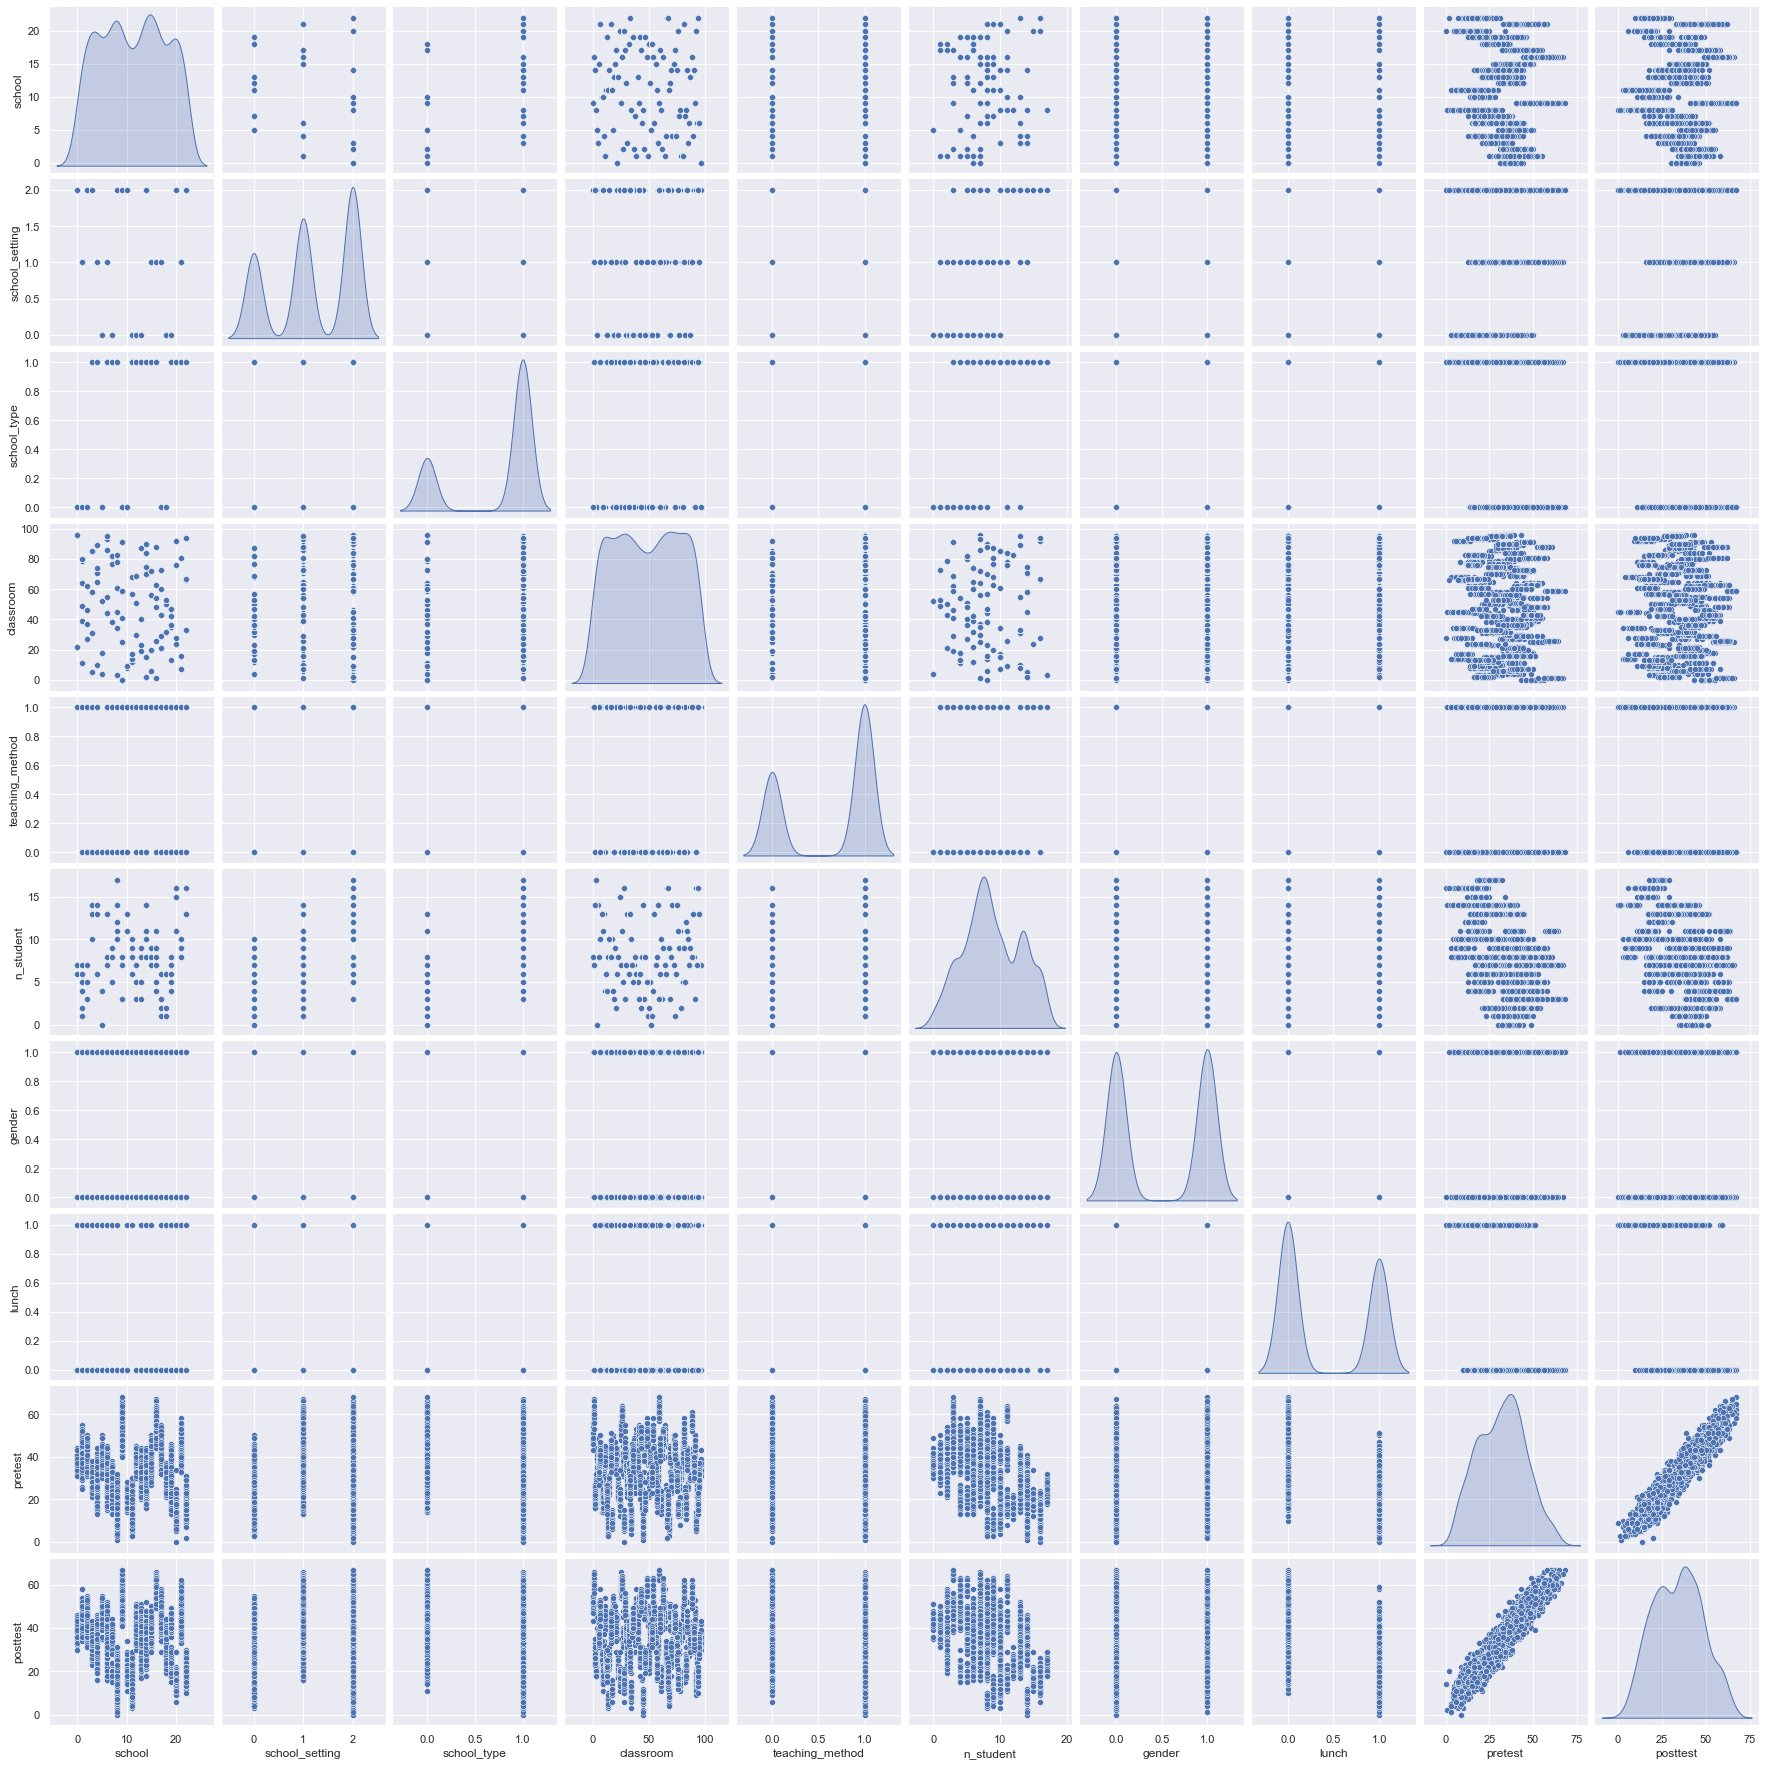

In [54]:
# plot between variables
sns.pairplot(corr_df, diag_kind='kde')

 Show correlation between variables - heatmap 


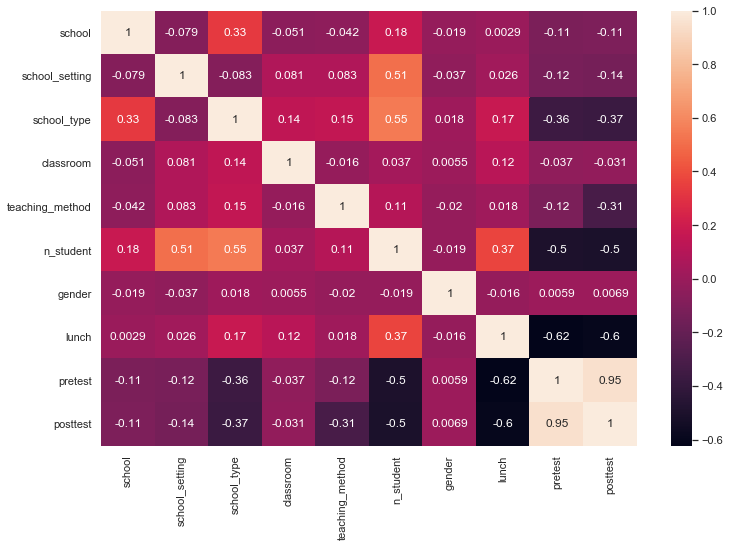

In [55]:
# strong connection between pretest score and post test score
print(colored(' Show correlation between variables - heatmap ', 'blue', attrs=['reverse', 'blink']))

plt.figure(figsize=(12,8))
sns.heatmap(corr_df.corr(),annot=True)

__Observation : correlation between variables__
* Strong connection between pretest and posttest score
* School, School_setting, School_type, classroom, n_student, gender, lunch - show similiar relationship score between pre and post. Only teaching method suggest more strong connection to posttest than pretest

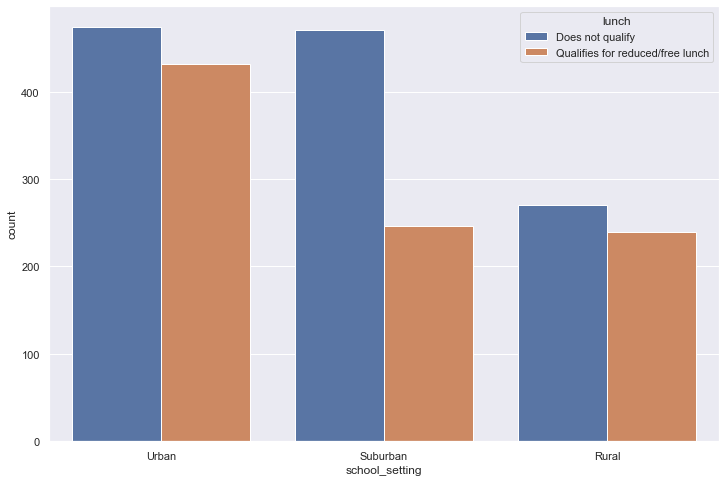

In [56]:
# number of students are not eligible for free lunch
plt.figure(figsize=(12,8))
sns.countplot(x="school_setting", hue="lunch", data=df)

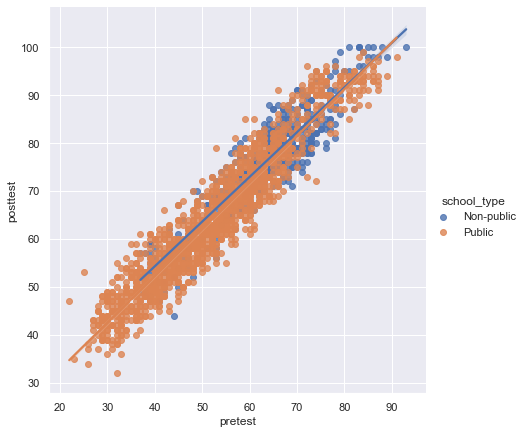

In [58]:
# Non-public school tend to have a higher pretest score
sns.lmplot(x='pretest',y='posttest',data = df,hue ='school_type',height= 6)

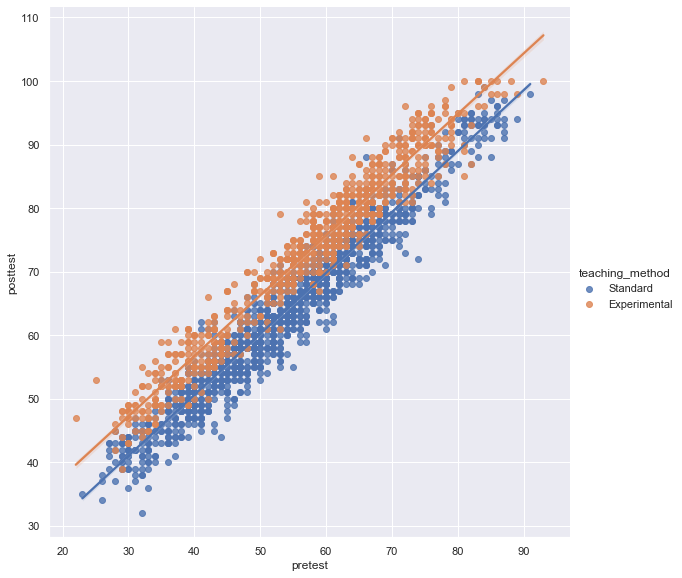

In [57]:
# How teching method effect pretest and posttest score
sns.lmplot(x='pretest',y='posttest',data = df,hue ='teaching_method',height= 8)

The plotted graph indicate that students who study in Experimental teaching method (orange color) usually has higher test score. 

In [40]:
# given summary of post-test result, how it perform after pre- test
conditions = [
    (corr_df['pretest'] == corr_df['posttest']),
    (corr_df['pretest'] < corr_df['posttest']),
    (corr_df['pretest'] > corr_df['posttest'])]
choices = ['same','higher','lower']
corr_df['summary'] = np.select(conditions, choices)
corr_df.head()

,school,school_setting,school_type,classroom,teaching_method,n_student,gender,lunch,pretest,posttest,summary
0,0,2,0,22,1,6,0,0,39,39,same
1,0,2,0,22,1,6,0,0,43,46,higher
2,0,2,0,22,1,6,1,0,41,43,higher
3,0,2,0,22,1,6,0,0,38,44,higher
4,0,2,0,22,1,6,1,0,41,43,higher


from above information, 99% of students have a better post test score, hence remove those who has lower or qual to pretest score

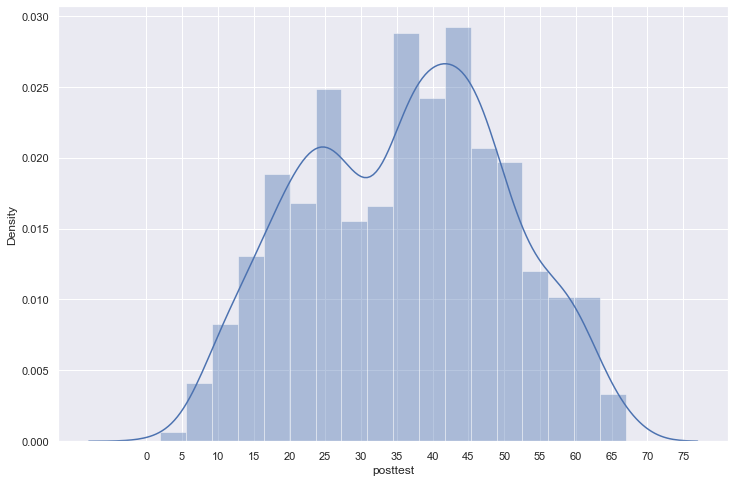

In [42]:
# filtered out student who are outlier, assigned new df name as "clean_df"
clean_df = corr_df[corr_df['summary']=='higher']
# # drop gender, due to it shows no effect on post test
clean_df = clean_df.drop(['gender','summary'],axis=1)


plt.subplots(figsize=(12,8))
plt.xticks(np.arange(0, 80, step=5))
sns.set_theme(style="darkgrid")
sns.distplot( clean_df["posttest"])

## Model fitting

In [95]:
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn import metrics



### Creating a Model on the entire data:

In [64]:
x = clean_df.drop(['posttest'],axis=1)
y = clean_df['posttest']

X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state = 123)

__LinearRegression__
As we see the pretest-posttest relation in a strightline, hence firstly try with linear regression

In [65]:
#LinearRegression
lr = LinearRegression()
#training the model on training data
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print('Accuracy - LinearRegression: %.2f%%'%(lr.score(X_test,y_test)*100))

Accuracy - LinearRegression: 96.51%


__GradientBoostingRegressor__

In [70]:
#GradientBoostingRegressor
gradientBoost = GradientBoostingRegressor(random_state=1234,learning_rate=0.03, n_estimators=300)
gradientBoost.fit(X_train,y_train)


print('Accuracy - GradientBoostingRegressor: %.2f%%'%(gradientBoost.score(X_test, y_test)*100))

Accuracy - GradientBoostingRegressor: 96.61%


__RandomForestRegressor__


In [75]:
#random forest regression

regr = RandomForestRegressor(max_depth=300, random_state=0, n_estimators=300)
regr.fit(X_train,y_train)

print('Accuracy - RandomForestRegression: %.2f%%'%(regr.score(X_test, y_test)*100))


Accuracy - RandomForestRegression: 96.71%


__AdaBoostRegressor__

In [89]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.datasets import make_regression

X, y = make_regression(n_features=300, n_informative=5,random_state=0, shuffle=False)
#Multi-layer Perceptron regressor
clf =MLPRegressor(hidden_layer_sizes=1000, activation='relu', solver='adam', alpha=0.0001
      , batch_size='auto', learning_rate='adaptive', learning_rate_init=0.005)
clf.fit(X_train,y_train)

print('Accuracy - Multi-layer Perceptron regressor: %.2f%%'%(clf.score(X_test, y_test)*100))


Accuracy - Multi-layer Perceptron regressor: 96.47%


__Output__

In [91]:
ans = regr.predict(X_test)

In [96]:
# distance from true val
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(y_test, ans))
#how well the regression model fits the observed data
print('R^2:', metrics.r2_score(y_test, ans))

Mean Absolute Error (MAE): 1.9841239373188995
Mean Squared Error (MSE): 6.217219035732282
Root Mean Squared Error (RMSE): 2.493435187794598
R^2: 0.9670538879956437


In [105]:
y_test_df

,posttest
0,44
1,62
2,37
3,17
4,20
5,32
6,22
7,56
8,35
9,43


In [104]:
# get predictive col
final_output = pd.DataFrame(ans,columns={"pred_posttest"})
#get true val col
y_test_df = pd.DataFrame(y_test, index=None,columns={"posttest"}).reset_index(drop=True)
# export output
pd.concat([final_output,y_test_df],axis=1).to_csv('Gelato_predict_testscore_output.csv')

In [107]:
# Thank you